In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from eegatscale.models import LinearHeadBENDR
from eegatscale.transforms import Standardize
from scipy.stats import ttest_ind
import torch
import tqdm

from captum.concept import TCAV, Concept
from captum.concept._utils.common import concepts_to_str
from concept_classifier import TCAVClassifier
import warnings
warnings.filterwarnings("ignore")

from dataset_utils import Experiment

In [141]:
concepts_dir = '/scratch/s194101/concepts/'

print(list(os.listdir(concepts_dir)))



['left_right_concepts_MMIDB_Gamma_new_T0', 'random_tuh_alpha_rh', 'random_mmidb_alpha_no_baseline_lh', 'random_left_concept_MMIDB_Alpha_sanity_check_1000_with_sigma', 'random_mmidb_alpha_no_baseline_with_sigma', 'sanity_check_concepts_MMIDB_alpha_no_baseline', 'random_right_concept_MMIDB_Alpha_sanity_check_1000_no_baseline', 'random_mmidb_alpha_baseline_T0_rh', 'random_mmidb_alpha_lh', 'mmidb_notebook_concepts_alpha', 'mmidb_alpha_baseline_rh_whole', 'sanity_check_concepts_MMIDB_alpha_baseline_with_sigma', 'random_right_concept_MMIDB_Alpha_sanity_check', 'mmidb_alpha_baseline_T2_whole', 'sanity_check_concepts_MMIDB_alpha_baseline', 'TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124', 'random_mmidb_alpha_rh', 'random_right_concept_MMIDB_Alpha_sanity_check_1000', 'mmidb_alpha_baseline_lh_whole', 'TUSZ', 'random_mmidb_alpha_baseline_T0_lh', 'random_tuh_alpha_1000', 'random_mmidb_alpha_no_baseline', 'mmidb_alpha_baseline_T1_whole', 'random_tuh_alpha_lh', 'random_mmidb_alpha_no

## Load Seizure model

In [142]:
out_features = 2
# encoder_path = "/scratch/agjma/checkpoints/tuh-noica-standardize-epoch=9-step=68317-val_loss=0.26.ckpt"

# best model on subset (before) # worse model
encoder_path = "/scratch/s194101/finetune_logs_all/tusz_noica_noica_60.0_nogroups_2/version_7/checkpoints/epoch=4-step=40.ckpt"


# best model on eval set
# encoder_path = "/scratch/s194101/finetune_logs_all/tusz_noica_noica_60.0_nogroups_whole_dataset/version_47/checkpoints/epoch=2-step=141.ckpt"

# best model on train set 97 %
# encoder_path = "/scratch/s194101/finetune_logs_all/tusz_noica_noica_60.0_nogroups_whole_dataset/version_1/checkpoints/epoch=13-step=658.ckpt"


model = LinearHeadBENDR(encoder_path, encoder_h=512, in_features=19, out_features=out_features)
state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))["state_dict"]
model.load_state_dict(state_dict)
model.eval()
print("model loaded")

Initialized mask embedding and position encoder from  /scratch/s194101/finetune_logs_all/tusz_noica_noica_60.0_nogroups_2/version_7/checkpoints/epoch=4-step=40.ckpt
model loaded


In [143]:
target_data = "TUSZ/seiz"
# target_data = "random_left_concept_MMIDB_Alpha_sanity_check"
# random_concept = "TUEV/random"
# random_concept = "random_tuh_selected_samples_60"
# random_concept = "TUSZ/bckg"
# random_concept = "random_tuh_all"
# random_concept = "random_tuh_alpha"
# random_concept = "tuev_random_concepts"
random_concept = "TUEV_subset/random"

concept_dir_names = [
    "TUEV/artf",
    "TUEV/bckg",
    "TUEV/gped",
    "TUEV/pled",
    "TUEV/spsw",
    ]
# concept_dir_names = [
#     "TUEV_subset/artf",
#     "TUEV_subset/bckg",
#     "TUEV_subset/gped",
#     "TUEV_subset/pled",
#     "TUEV_subset/spsw",
#     ]
experiments = []
idx = 0
n_concept_samples = 50
n_runs = 100
for concept_dir_name in concept_dir_names:
    exp = Experiment(model,
                    target_data,
                    concepts_dir,
                    [
                    concept_dir_name, # this is where you add extra concepts, (in the square brackets)
                    random_concept,
                    ],
                    verbose=True,
                    n_concept_samples=n_concept_samples,
                    n_runs=n_runs,
                    internal_concept_idx=idx,
                    # batch_size = 50,
                    )
    experiments.append(exp)
    idx += 1000



Loaded dataset TUEV/artf with 1586 samples
Loaded dataset TUEV_subset/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples
Loaded dataset TUEV/bckg with 3209 samples
Loaded dataset TUEV_subset/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples
Loaded dataset TUEV/gped with 2343 samples
Loaded dataset TUEV_subset/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples
Loaded dataset TUEV/pled with 1976 samples
Loaded dataset TUEV_subset/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples
Loaded dataset TUEV/spsw with 139 samples
Loaded dataset TUEV_subset/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples


In [144]:
# plt_name = f"tusz_seizure_best_eval_model_concepts{n_concept_samples}_runs{n_runs}_vs_{random_concept.replace('/', '_')}"
# plt_name = f"tusz_seizure_best_train_model_concepts{n_concept_samples}_runs{n_runs}_vs_{random_concept.replace('/', '_')}"
plt_name = f"tusz_seizure_worse_model{n_concept_samples}_runs{n_runs}_vs_{random_concept.replace('/', '_')}"

In [145]:
experiment = experiments[0]
f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0].split('/')[-1]}.pkl" if "/" in experiment.concept_names[0] else f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0]}.pkl"

'/home/s194101/Bachelors-explainability/TUSZ/seiz_artf.pkl'

In [146]:
experiments[0].inputs

model(experiments[0].inputs).argmax(dim=1)

tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0])

In [147]:
# next(iter(experiments[1].concepts["TUEV/bckg"][0].data_iter)).shape
# experiments[1].concepts

# model(next(iter(experiments[1].concepts["TUEV/bckg"][0].data_iter)))

In [148]:
layers = ["encoder", "enc_augment", "summarizer", "extended_classifier", "clf"]

def run_tcav(experiment:Experiment, layers:list):
    if "/" in experiment.concept_names[0]:
        save_path = f"/scratch/s194101/temp/cav/{experiment.concept_names[0].split('/')[-1]}/"
    else:
        save_path = f"/scratch/s194101/temp/cav/{experiment.concept_names[0]}/"
    tcav = TCAV(model, layers, model_id="BendrModel", classifier=TCAVClassifier(), save_path=save_path)
    # tcav = TCAV(model, layers, save_path=save_path)
    tcav_scores = tcav.interpret(inputs=experiment.inputs, experimental_sets=experiment.experimental_sets, target=0)
    tcav_scores = dict(tcav_scores)

    save_path = f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0].split('/')[-1]}.pkl" if "/" in experiment.concept_names[0] else f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0]}.pkl"
    with open(save_path, "wb") as f:
        pickle.dump(
            {"tcav_scores": tcav_scores,
             "experimental_sets": experiment.experimental_sets,},f)
    return tcav_scores
        

In [149]:
# tcav = TCAV(model, layers, model_id="BendrModel", classifier=TCAVClassifier(), save_path="/scratch/s194101/temp/cav_test/")
# tmp_scores = tcav.interpret(inputs=experiments[0].inputs, experimental_sets=[experiments[0].experimental_sets[0], experiments[1].experimental_sets[0]], target=0)


In [150]:
# next(iter(experiments[0].concepts["TUEV/artf"][0].data_iter)).shape

In [151]:
# tmp_scores

In [ ]:
for exp in experiments:
    run_tcav(exp, layers)
    print(exp.inputs_name, exp.concept_names[0])

TUSZ/seiz TUEV/artf


In [ ]:
all_experimental_sets = []
all_tcav_scores = []

for i, exp in enumerate(experiments):
    file_path = f"/home/s194101/Bachelors-explainability/{exp.inputs_name}_{exp.concept_names[0].split('/')[-1]}.pkl" if "/" in exp.concept_names[0] else f"/home/s194101/Bachelors-explainability/{exp.inputs_name}_{exp.concept_names[0]}.pkl"
    with open(file_path, "rb") as f:
        data = pickle.load(f)
        all_tcav_scores.append(data["tcav_scores"])
        all_experimental_sets.append(data["experimental_sets"])

In [ ]:
from plot_utils import assemble_scores, plot_tcav_scores, plot_tcav_scores_plotly

pval: 3.428163847859765e-21, pval_whit: 8.2699870569150945e-19
pval: 2.121767578043809e-21, pval_whit: 6.772150655744033e-19
pval: 0.2643276175920047, pval_whit: 0.29373265713785257
pval: 0.15886957060688942, pval_whit: 0.15875743750830362
pval: 0.048014827013685826, pval_whit: 0.04843494108143848
pval: 2.6141844324656148e-08, pval_whit: 3.1862085751659334e-07
pval: 0.05126418359913434, pval_whit: 0.009776601826202876
pval: 4.696265640521551e-07, pval_whit: 6.463652530555622e-06
pval: 3.85298864697677e-06, pval_whit: 6.39939933243881e-06
pval: 0.260129345726273, pval_whit: 0.2596882799123623
pval: 3.601892971278733e-14, pval_whit: 3.1138973587912843e-13
pval: 1.831708227065446e-10, pval_whit: 9.532356809844054e-13
pval: 0.039959236231460436, pval_whit: 0.01489980186945808
pval: 0.04801483373766322, pval_whit: 0.04843494108143848
pval: 0.39868627100214904, pval_whit: 0.39811447647615206
pval: 4.2795446743104416e-36, pval_whit: 7.976313378330488e-26
pval: 3.200310014762265e-29, pval_whit

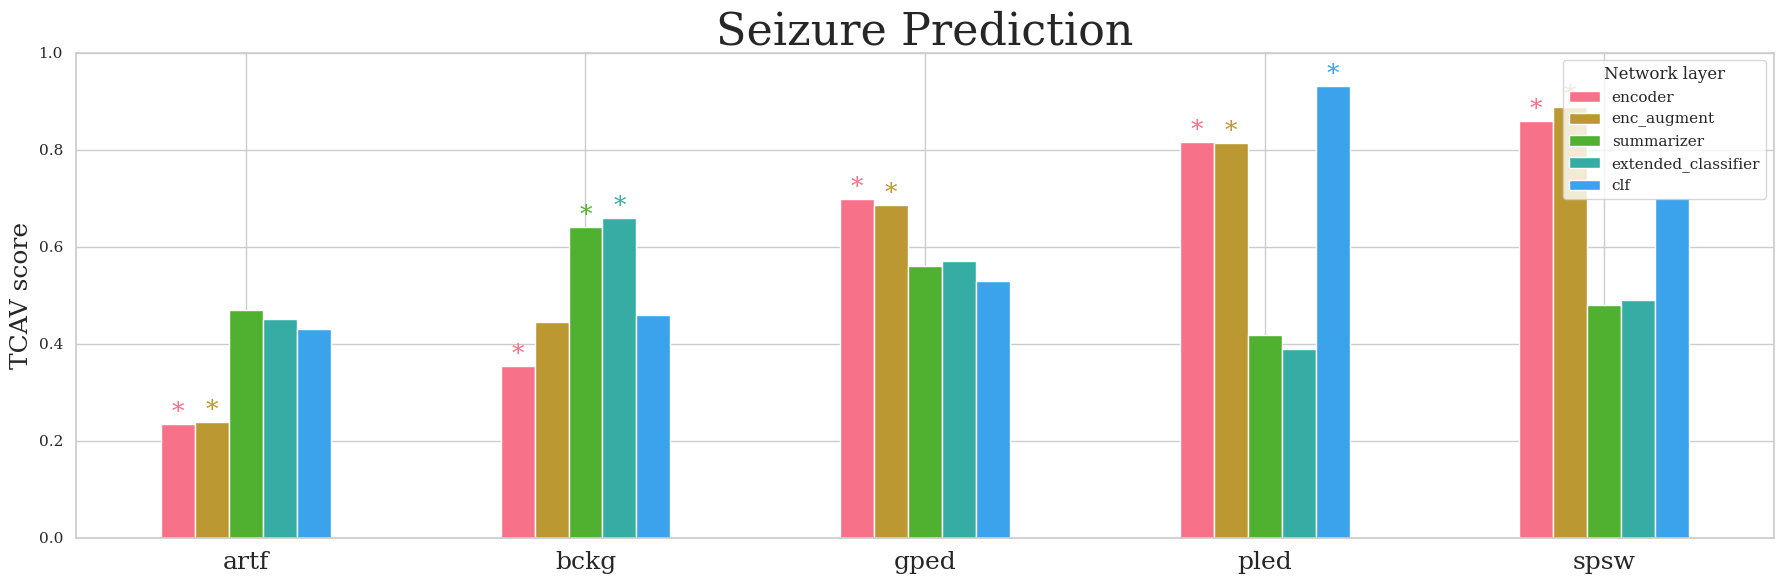

pval: 3.428163847859765e-21, pval_whit: 8.2699870569150945e-19
pval: 2.121767578043809e-21, pval_whit: 6.772150655744033e-19
pval: 0.2643276175920047, pval_whit: 0.29373265713785257
pval: 0.15886957060688942, pval_whit: 0.15875743750830362
pval: 0.048014827013685826, pval_whit: 0.04843494108143848
pval: 2.6141844324656148e-08, pval_whit: 3.1862085751659334e-07
pval: 0.05126418359913434, pval_whit: 0.009776601826202876
pval: 4.696265640521551e-07, pval_whit: 6.463652530555622e-06
pval: 3.85298864697677e-06, pval_whit: 6.39939933243881e-06
pval: 0.260129345726273, pval_whit: 0.2596882799123623
pval: 3.601892971278733e-14, pval_whit: 3.1138973587912843e-13
pval: 1.831708227065446e-10, pval_whit: 9.532356809844054e-13
pval: 0.039959236231460436, pval_whit: 0.01489980186945808
pval: 0.04801483373766322, pval_whit: 0.04843494108143848
pval: 0.39868627100214904, pval_whit: 0.39811447647615206
pval: 4.2795446743104416e-36, pval_whit: 7.976313378330488e-26
pval: 3.200310014762265e-29, pval_whit

In [ ]:
concept_names = ["artf", "bckg", "gped", "pled", "spsw"]
title = "Seizure Prediction"
# plt_name = "TUEV_seizure_tuev_vs_random_tuh"

scores_mean_df, scores_std_df = plot_tcav_scores(all_experimental_sets, all_tcav_scores, concept_names=concept_names, title=title, score_type="sign_count", alpha=0.05, only_significant=False, with_error=False, plt_name=plt_name, file_type="png")
# scores_mean_df
# scores_std_df
plot_tcav_scores_plotly(all_experimental_sets, all_tcav_scores, concept_names=concept_names, title=title, score_type="sign_count", alpha=0.05, only_significant=False, with_error=False, plt_name=plt_name, file_type="png")
